In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.gridspec as gridspec
import math
from influxdb_client import InfluxDBClient


In [27]:
from common import (
    sensor_types, sensor_type_mapping,
    get_influx_client
)


# InfluxDB 연결
client, INFLUX_BUCKET = get_influx_client()
read_api = client.query_api()

# 센서 타입 필터 생성
sensor_filter = ' or '.join([f'r["type"] == "{t}"' for t in sensor_types])

# Flux 쿼리 작성
flux = f'''
from(bucket: "{INFLUX_BUCKET}")
  |> range(start: -1d)
  |> filter(fn: (r) => r["_measurement"] == "sensor")
  |> filter(fn: (r) => r["_field"] == "value")
  |> filter(fn: (r) => {sensor_filter})
  |> aggregateWindow(every: 5m, fn: mean, createEmpty: false)
  |> yield(name: "mean")
'''

# 데이터 쿼리 및 전처리
df = read_api.query_data_frame(flux)

if isinstance(df, list):
    df = pd.concat(df)

df = df.reset_index().rename(columns={"_time": "time"})
df = df.set_index("time")

# 데이터 확인
print("데이터 샘플:")
display(df.head())
print(f"데이터 크기: {df.shape}")


/opt/homebrew/anaconda3/lib/python3.12/site-packages/influxdb_client/client/warnings.py:31: MissingPivotFunction: The query doesn't contains the pivot() function.

The result will not be shaped to optimal processing by pandas.DataFrame. Use the pivot() function by:

    
from(bucket: "coffee-mqtt")
  |> range(start: -1d)
  |> filter(fn: (r) => r["_measurement"] == "sensor")
  |> filter(fn: (r) => r["_field"] == "value")
  |> filter(fn: (r) => r["type"] == "co2" or r["type"] == "distance" or r["type"] == "humidity" or r["type"] == "illumination" or r["type"] == "infrared" or r["type"] == "pressure" or r["type"] == "temperature" or r["type"] == "infrared_and_visible" or r["type"] == "occupancy" or r["type"] == "battery_level" or r["type"] == "activity" or r["type"] == "battery")
  |> aggregateWindow(every: 5m, fn: mean, createEmpty: false)
  |> yield(name: "mean")
 |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")

You can disable this warning by:
    import warnin

데이터 샘플:


,index,result,table,_start,_stop,_value,_field,_measurement,location,type
time,,,,,,,,,,
2025-04-24 02:15:00+00:00,0,mean,0,2025-04-24 02:11:40.756604+00:00,2025-04-25 02:11:40.756604+00:00,32.0,value,sensor,2,battery
2025-04-24 02:20:00+00:00,1,mean,0,2025-04-24 02:11:40.756604+00:00,2025-04-25 02:11:40.756604+00:00,32.0,value,sensor,2,battery
2025-04-24 02:25:00+00:00,2,mean,0,2025-04-24 02:11:40.756604+00:00,2025-04-25 02:11:40.756604+00:00,32.0,value,sensor,2,battery
2025-04-24 02:30:00+00:00,3,mean,0,2025-04-24 02:11:40.756604+00:00,2025-04-25 02:11:40.756604+00:00,32.0,value,sensor,2,battery
2025-04-24 02:35:00+00:00,4,mean,0,2025-04-24 02:11:40.756604+00:00,2025-04-25 02:11:40.756604+00:00,32.0,value,sensor,2,battery


데이터 크기: (8482, 10)


In [28]:
df = df[df["location"]!="냉장고 내부"]

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8348 entries, 2025-04-24 02:15:00+00:00 to 2025-04-25 02:05:00+00:00
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   index         8348 non-null   int64              
 1   result        8348 non-null   object             
 2   table         8348 non-null   int64              
 3   _start        8348 non-null   datetime64[ns, UTC]
 4   _stop         8348 non-null   datetime64[ns, UTC]
 5   _value        8348 non-null   float64            
 6   _field        8348 non-null   object             
 7   _measurement  8348 non-null   object             
 8   location      8348 non-null   object             
 9   type          8348 non-null   object             
dtypes: datetime64[ns, UTC](2), float64(1), int64(2), object(5)
memory usage: 717.4+ KB


# 장소별 데이터 분석

In [30]:
# pivot_df 생성 및 전처리
pivot_df = df.reset_index().pivot_table(
    index=['time', 'location'],
    columns='type',
    values='_value'
).reset_index()

# 인덱스 설정
pivot_df = pivot_df.set_index('time')

# 인덱스 초기화하여 중복 문제 해결
pivot_df_reset = pivot_df.reset_index(drop=False).copy()

# 장소별 센서 데이터 비교 분석을 위해 온도, 습도, co2 변수 선택
variables = [ 'temperature', 'humidity', 'co2', 'tvoc', 'pressure', 
    'occupancy', 'activity', 'distance', 
    'illumination', 'infrared', 'infrared_and_visible']

# 사용 가능한 변수만 필터링
available_vars = [var for var in variables if var in pivot_df_reset.columns]

# 장소별 평균값 계산
location_means = pivot_df_reset.groupby('location')[available_vars].mean().sort_values(by='temperature', ascending=False)

print("장소별 센서 데이터 평균값:")
print(location_means)


장소별 센서 데이터 평균값:
type              temperature   humidity         co2     pressure  occupancy  \
location                                                                       
보드                  23.910562  45.370802  581.893561  1008.701326        NaN   
왼쪽 뒤                23.671717  42.598706  641.061237  1008.642803        NaN   
8인 책상               23.446833  37.116995  499.497162          NaN        NaN   
안쪽벽 중앙              23.065354  45.263780         NaN          NaN        NaN   
정수기 위               22.941628  39.028740         NaN          NaN        NaN   
안쪽 분리벽              22.917323  35.874016         NaN          NaN        NaN   
스마트팜                22.736121        NaN         NaN          NaN        NaN   
입구                  17.731858  62.694969  645.298430  1001.278766        NaN   
2                         NaN        NaN         NaN          NaN    0.00062   
24e124535d084198          NaN        NaN         NaN          NaN        NaN   
출입문                     

<Figure size 1800x1000 with 0 Axes>

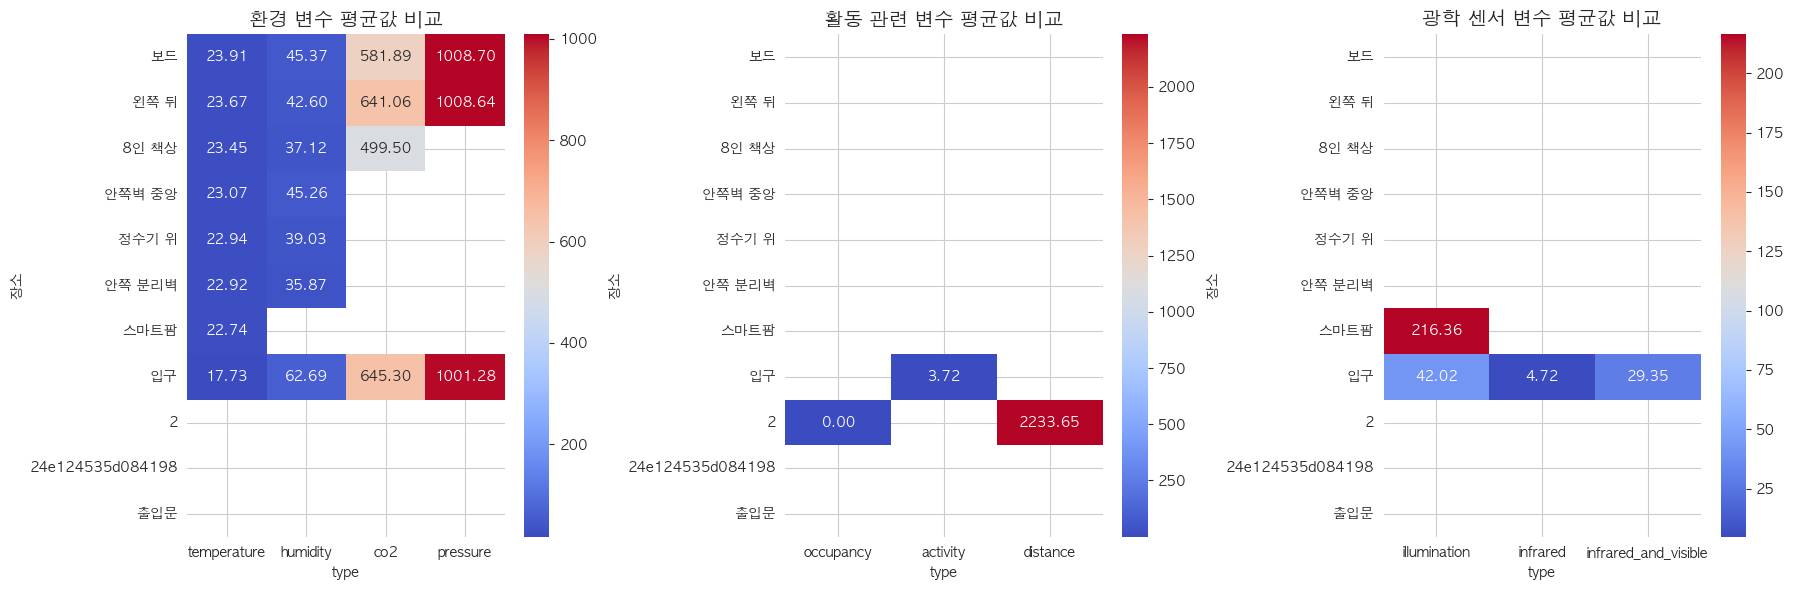

In [31]:
# 변수 그룹화
env_vars = ['temperature', 'humidity', 'co2', 'pressure']
activity_vars = ['occupancy', 'activity', 'distance']
optical_vars = ['illumination', 'infrared', 'infrared_and_visible']

# 사용 가능한 변수만 필터링
available_env_vars = [var for var in env_vars if var in pivot_df_reset.columns]
available_activity_vars = [var for var in activity_vars if var in pivot_df_reset.columns]
available_optical_vars = [var for var in optical_vars if var in pivot_df_reset.columns]

# 1. 그룹별 히트맵을 서브플롯으로 구성
plt.figure(figsize=(18, 10))

# 그룹 개수 계산 (비어있지 않은 그룹만)
valid_groups = []
for group_name, group_vars in [
    ('환경 변수', available_env_vars),
    ('활동 관련 변수', available_activity_vars),
    ('광학 센서 변수', available_optical_vars)
]:
    if group_vars:
        valid_groups.append((group_name, group_vars))

# 서브플롯 레이아웃 설정
n_groups = len(valid_groups)
if n_groups > 0:
    fig, axes = plt.subplots(1, n_groups, figsize=(6*n_groups, 6))
    
    # 그룹이 하나인 경우 axes를 리스트로 변환
    if n_groups == 1:
        axes = [axes]
    
    for i, (group_name, group_vars) in enumerate(valid_groups):
        sns.heatmap(location_means[group_vars], annot=True, cmap='coolwarm', 
                   fmt='.2f', ax=axes[i])
        axes[i].set_title(f'{group_name} 평균값 비교', fontsize=14)
        axes[i].set_ylabel('장소')
    
    plt.tight_layout()
    plt.savefig('img/장소별_그룹별_평균값.png', dpi=300, bbox_inches='tight')
    plt.show()


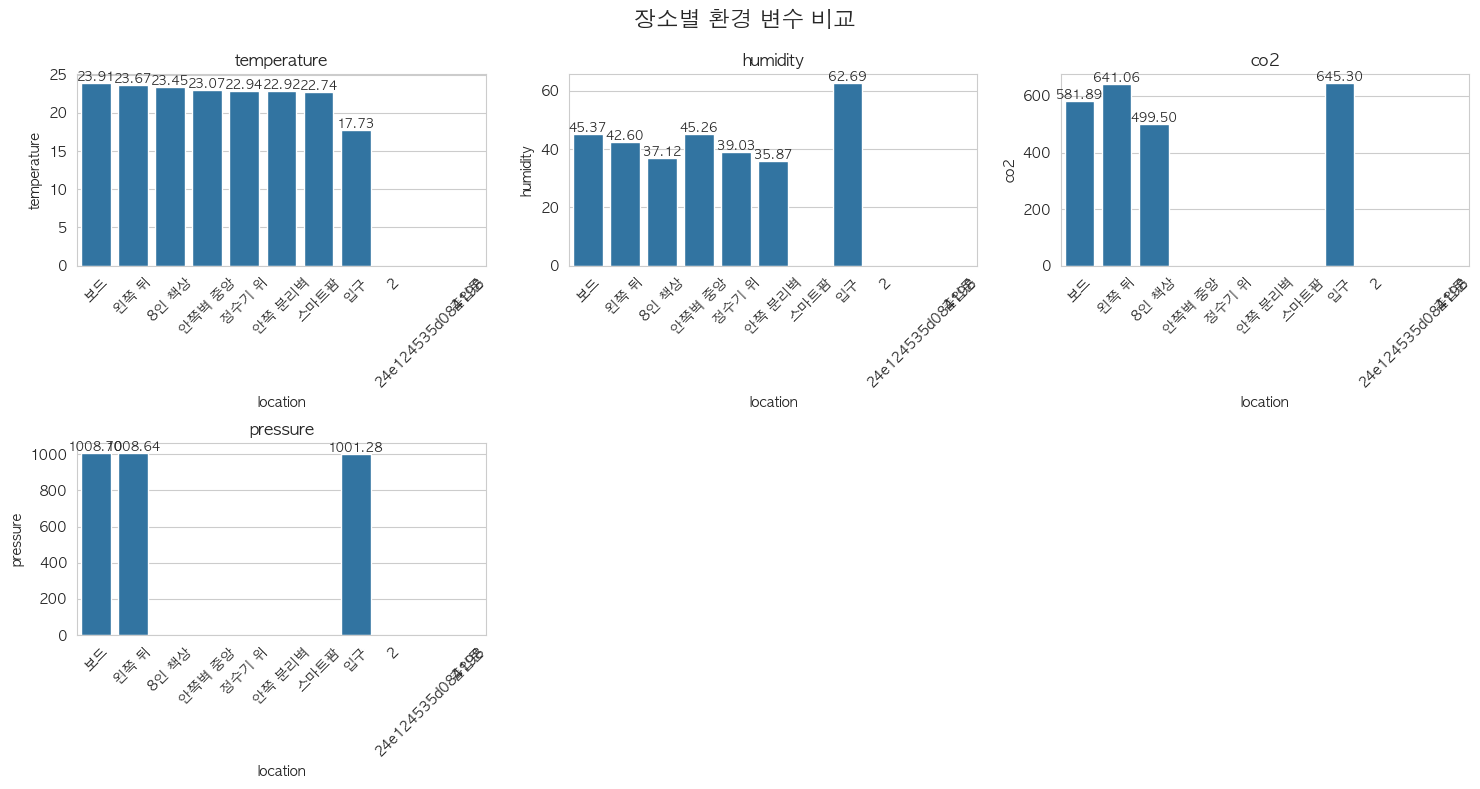

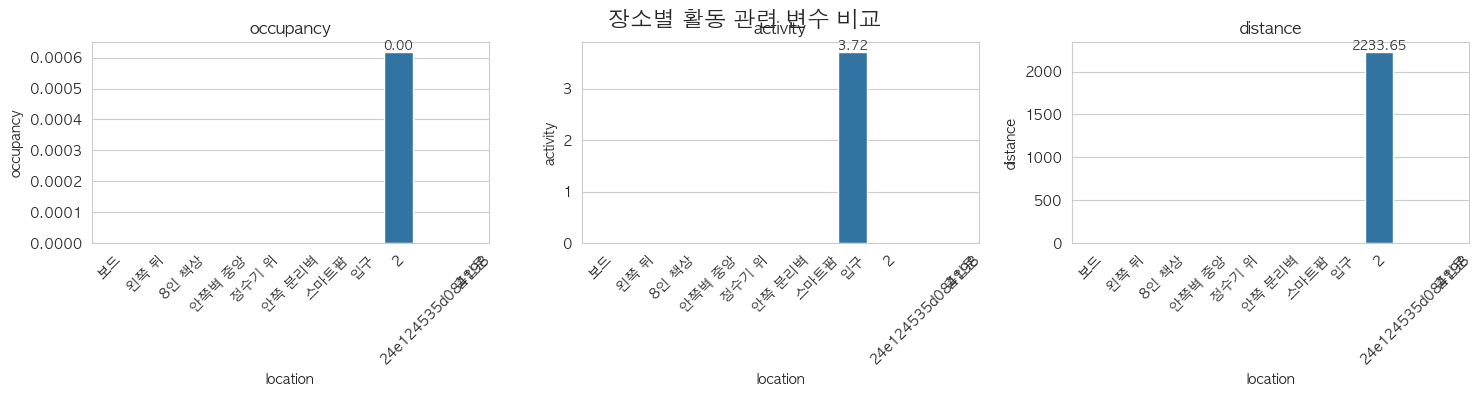

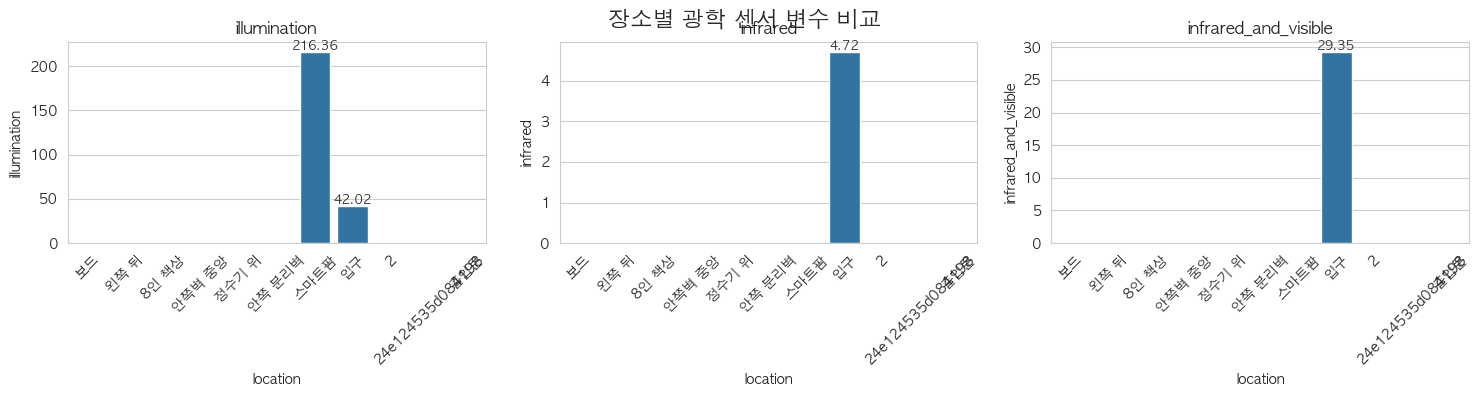

In [32]:
# 2. 각 그룹 내 변수별 막대 그래프를 서브플롯으로 구성
for group_name, group_vars in [
    ('환경 변수', available_env_vars),
    ('활동 관련 변수', available_activity_vars),
    ('광학 센서 변수', available_optical_vars)
]:
    if not group_vars:
        continue
        
    # 변수 개수에 따라 서브플롯 행/열 계산
    n_vars = len(group_vars)
    n_cols = min(3, n_vars)  # 최대 3개 열
    n_rows = math.ceil(n_vars / n_cols)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    
    # 1차원 배열로 변환 (단일 행/열일 경우 처리)
    if n_vars == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    for i, var in enumerate(group_vars):
        if i < len(axes):  # 안전 검사
            sns.barplot(x=location_means.index, y=location_means[var], ax=axes[i])
            axes[i].set_title(f'{var}', fontsize=12)
            axes[i].set_ylabel(var)
            axes[i].tick_params(axis='x', rotation=45)
            
            # 막대 위에 값 표시
            for j, v in enumerate(location_means[var]):
                if not np.isnan(v):  # NaN 값 처리
                    axes[i].text(j, v, f'{v:.2f}', ha='center', va='bottom', fontsize=9)
    
    # 사용하지 않는 서브플롯 숨기기
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    
    plt.suptitle(f'장소별 {group_name} 비교', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # 제목 공간 확보
    plt.savefig(f'img/location/장소별_{group_name}_막대그래프.png', dpi=300, bbox_inches='tight')
    plt.show()

/var/folders/lf/y10g6sqx1r31qpbktbvwk_f00000gn/T/ipykernel_10652/858774848.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  location_discomfort = pivot_df_reset.groupby('location').apply(


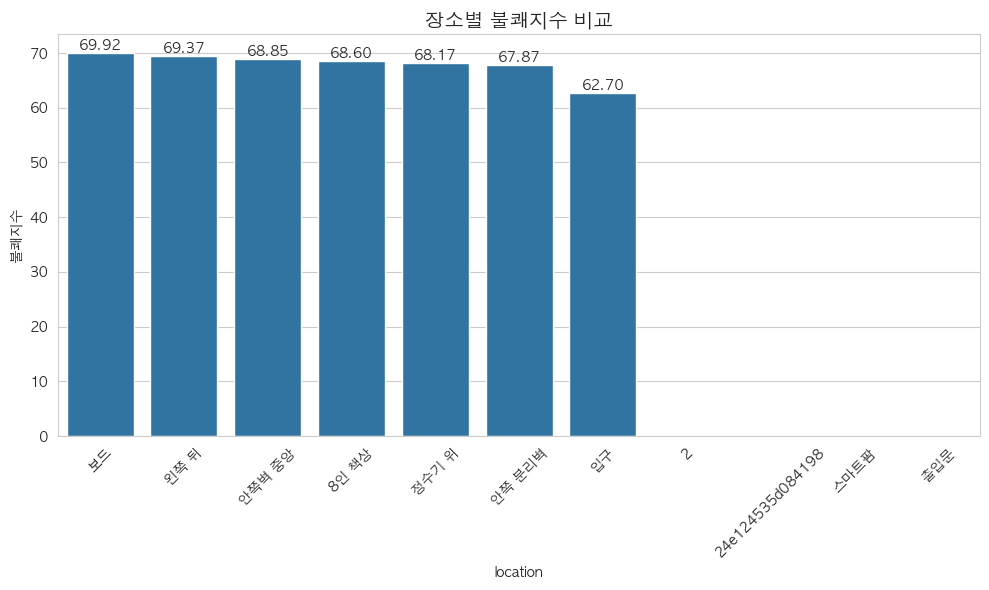

In [33]:

# 3. 불쾌지수 계산 및 시각화 (온도와 습도 데이터가 있는 경우)
if 'temperature' in pivot_df_reset.columns and 'humidity' in pivot_df_reset.columns:
    # 불쾌지수 계산 함수
    def calculate_discomfort_index(temp, humidity):
        return 0.81 * temp + 0.01 * humidity * (0.99 * temp - 14.3) + 46.3
    
    # 장소별 불쾌지수 계산
    location_discomfort = pivot_df_reset.groupby('location').apply(
        lambda x: calculate_discomfort_index(x['temperature'].mean(), x['humidity'].mean())
    ).sort_values(ascending=False)
    
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=location_discomfort.index, y=location_discomfort.values)
    plt.title('장소별 불쾌지수 비교', fontsize=14)
    plt.ylabel('불쾌지수')
    plt.tick_params(axis='x', rotation=45)
    
    # 막대 위에 값 표시
    for i, v in enumerate(location_discomfort.values):
        ax.text(i, v, f'{v:.2f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig('img/location/장소별_불쾌지수_비교.png', dpi=300, bbox_inches='tight')
    plt.show()